In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import pearsonr

import sys
sys.path.append("..")
import utils.utils as utils
from data_preparation.data_preparation_pos import read_conll, ABSATokenizer

## PoS

### Stats

In [2]:
def pos_ttr(info, output, tokenizer):
    lang_name = info["lang_name"]
    file_path = info["file_path"]
    dataset = info["dataset"]
    
    ids, words, tags = read_conll(file_path)
    words = np.array(words).sum() # Flatten list of lists
    prop_tags = np.array(tags).sum()
    
    tokens = tokenizer.subword_tokenize(words, prop_tags)[0]
    types = np.unique(tokens)
    ttr = len(types) / len(tokens)
    word_types = np.unique(words)
    twr = len(word_types) / len(words)
    
    if lang_name in output.keys():
        output[lang_name][dataset + "_ttr"] = ttr
        output[lang_name][dataset + "_twr"] = twr
    else:
        output[lang_name] = {dataset + "_ttr": ttr, dataset + "_twr": twr}
    return output

In [3]:
tokenizer = ABSATokenizer.from_pretrained("bert-base-multilingual-cased")

In [4]:
pos_ttr_stats = utils.run_through_data("../data/ud/", pos_ttr, table={}, tokenizer=tokenizer)

In [5]:
df = pd.DataFrame(pos_ttr_stats).T
df = df[["train_ttr", "dev_ttr", "test_ttr", "train_twr", "dev_twr", "test_twr"]].reset_index().rename(
    columns={"index": "Language"})
df = utils.order_table(df)

In [6]:
gerz_ttr = [0.11, 0.07, 0.15, 0.14, 0.14, 0.06, 0.04, 0.05, 0.2, 0.13, 0.06, 0.22, 0.14, 0.12, 0.12]

In [7]:
df["grez_ttr"] = gerz_ttr

In [8]:
df["dif_grez_ttr"] = df["test_ttr"] - df["grez_ttr"]

In [9]:
df["dif_grez_ttr_%"] = df["dif_grez_ttr"] / df["grez_ttr"] * 100

In [10]:
#df.to_excel("pos_type_to_token.xlsx", index=False)

### Plots

In [2]:
df = pd.read_excel("pos_type_to_token.xlsx")

In [3]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

In [4]:
df = utils.add_lang_groups(df)

In [5]:
df.head()

,group,Language,train_ttr,dev_ttr,test_ttr,train_twr,dev_twr,test_twr,grez_ttr,dif_grez_ttr,dif_grez_ttr_%
0,Fusional,Bulgarian,0.021832,0.109246,0.108219,0.201446,0.378395,0.379929,0.11,-0.001781,-1.619057
1,Fusional,English,0.113564,0.220004,0.252234,0.151215,0.239851,0.270689,0.07,0.182234,260.334508
2,Fusional,Russian,0.069500,0.225115,0.160829,0.343497,0.493637,0.411625,0.15,0.010829,7.219626
3,Fusional,Slovak,0.043208,0.180458,0.159413,0.261917,0.472508,0.464308,0.14,0.019413,13.866165
4,Fusional,Croatian,0.036378,0.128422,0.121269,0.212388,0.360712,0.357502,0.14,-0.018731,-13.379253


In [6]:
plot_df = pd.concat([df, df], ignore_index=True)

In [7]:
plot_df.loc[15:, "test_ttr"] = plot_df.loc[15:, "test_twr"]

In [8]:
plot_df["Token-Word"] = ["Token"] * 15 + ["Word"] * 15

In [9]:
g.fig.axes[1].

SyntaxError: invalid syntax (<ipython-input-9-952b001df9a3>, line 1)

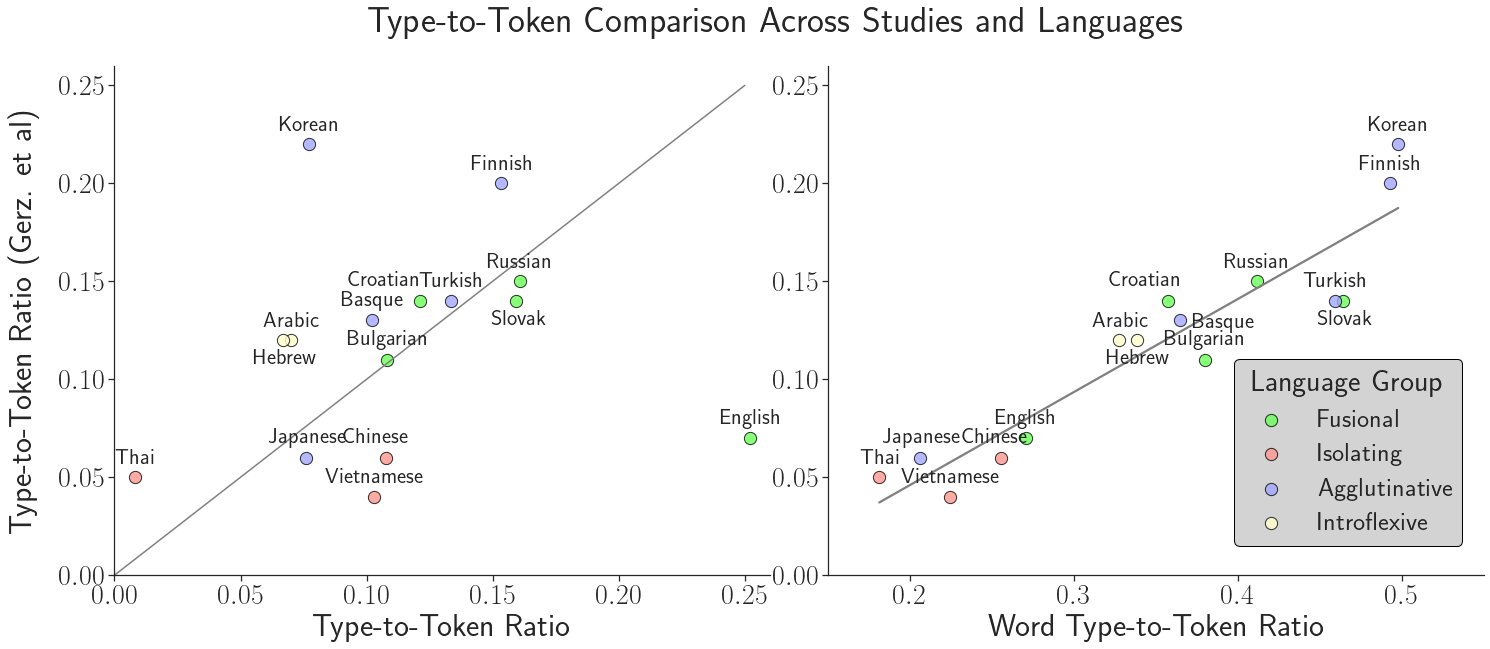

In [14]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 8

x = "test-ttr"
y = "grez-ttr"
hue = "group"
langs = "Language"
data = plot_df.rename(columns={"test_ttr": "test-ttr", "grez_ttr": "grez-ttr"})
offsets = dict.fromkeys(data[langs].values, (0, 0.007))
offsets["Slovak"] = (0.001, -0.012)
offsets["Hebrew"] = (0.001, -0.012)
offsets["Croatian"] = (-0.014, 0.007)
offsets["Chinese"] = (-0.004, 0.007)

g = sns.lmplot(x=x, y=y, data=data, hue=hue, palette=colors, col="Token-Word", sharex=False, sharey=False,
               fit_reg=False, legend=False, height=8, aspect=1.25, scatter_kws={"s": 150, "edgecolors": "black"})
g.fig.axes[0].plot([0,0.25],[0,0.25], "grey")
sns.regplot(x=x, y=y, data=data.loc[15:], ax=g.fig.axes[1],
            scatter=False, color="grey", ci=None)

for i, row in data.iterrows():
    if i // 15 and row[langs] == "Basque":
        offsets["Basque"] = (0.026, -0.004)
    g.fig.axes[i // 15].text(row[x] + offsets[row[langs]][0], row[y] + offsets[row[langs]][1], row[langs], 
                             fontsize=14 + extra_fontsize, horizontalalignment="center")

plt.legend(title="Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.6, 0.45), fontsize=18 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.4)

g.fig.axes[0].set_xlim((0, 0.26))
g.fig.axes[1].set_xlim((0.15, 0.55))
g.fig.axes[0].set_ylim((0, 0.26))
g.fig.axes[1].set_ylim((0, 0.26))

g.fig.axes[0].set_ylabel("Type-to-Token Ratio (Gerz. et al)", fontsize=24 + extra_fontsize, labelpad=20)
g.fig.axes[1].set_ylabel("")
g.fig.axes[0].set_xlabel("Type-to-Token Ratio", fontsize=24 +  extra_fontsize)
g.fig.axes[1].set_xlabel("Word Type-to-Token Ratio", fontsize=24 +  extra_fontsize)
g.fig.axes[0].set_title("")
g.fig.axes[1].set_title("")
g.fig.axes[0].tick_params(labelsize=20 + extra_fontsize)
g.fig.axes[1].tick_params(labelsize=20 + extra_fontsize)
g.fig.suptitle("Type-to-Token Comparison Across Studies and Languages", fontsize=28 +  extra_fontsize, y=1.05)

#plt.savefig("../data_exploration/plots/type_to_token_comparison.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [11]:
plot_df = df.copy()

In [12]:
plot_df = plot_df[["Language", "test_ttr", "grez_ttr"]]

In [13]:
plot_df = utils.add_lang_groups(plot_df, "Group")

In [14]:
plot_df = pd.melt(plot_df, id_vars=["Group", "Language"], value_vars=["test_ttr", "grez_ttr"], 
                  var_name="dataset", value_name="ttr")

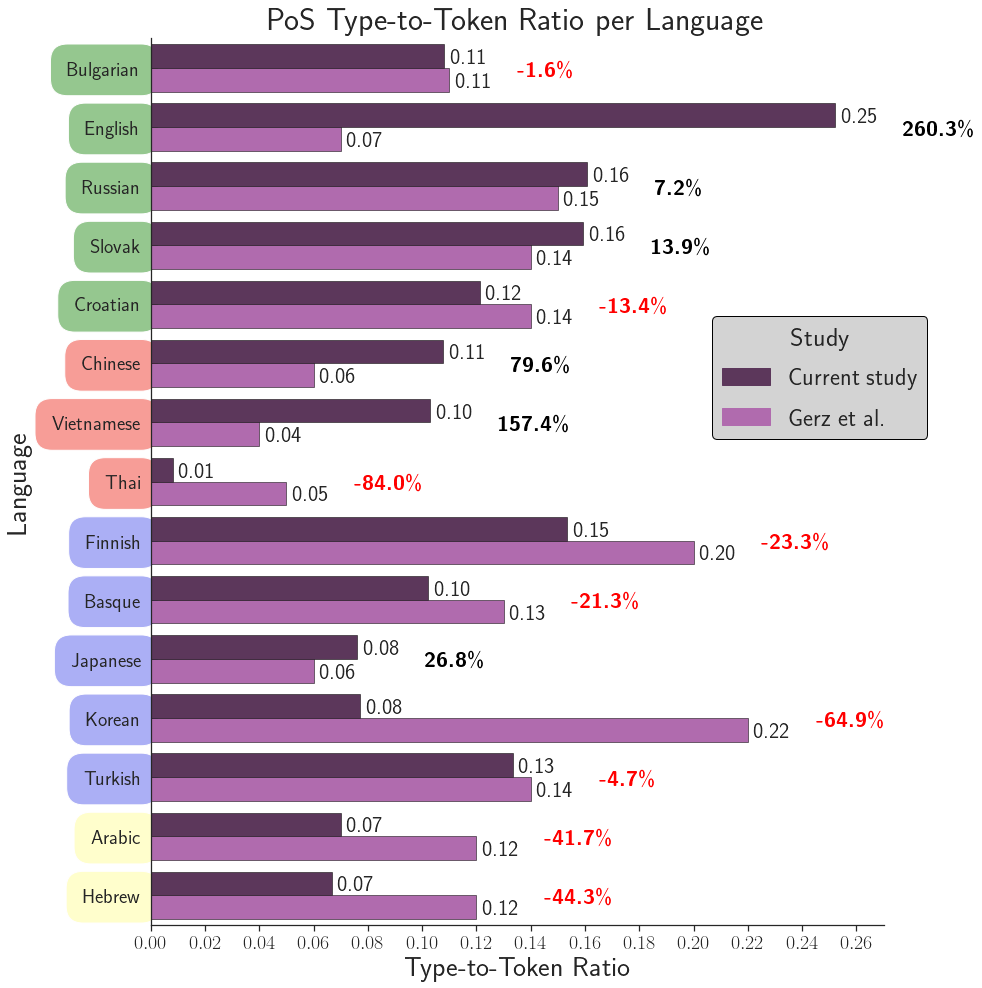

In [299]:
def scale_y(y, langs):
    return 1 - y / len(langs)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
bar_colors = ["#870c85", "#ff1cfb"]
label_colors = np.array([np.repeat(color, times).tolist() for color, times in zip(colors, [5, 3, 5, 2])]).sum()
extra_fontsize = 4

g = sns.catplot(
    data=plot_df, kind="bar", x="ttr", y="Language", hue="dataset",
    height=13, aspect=0.9, palette=bar_colors, saturation=0.3, legend=False, edgecolor="black", linewidth=0.5
)

langs = plot_df["Language"].unique().tolist()

for lang in langs:
    values = plot_df.loc[(plot_df["Language"] == lang), "ttr"].values
    dy = [-0.175, 0.225]
    for i in range(len(values)):
        g.ax.text(values[i] + 0.002, langs.index(lang) + dy[i], "{:.2f}".format(values[i]), 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
    
    # Difference
    diff = df.loc[langs.index(lang), "dif_grez_ttr_%"]
    if diff > 0:
        color = "black"
    else:
        color = "red"
    g.ax.text(values.max() + 0.025, langs.index(lang) + 0.05, r"\textbf{{{:.1f}}}\%".format(diff), 
                  verticalalignment="center", horizontalalignment="left", color=color,
                  fontsize=18 + extra_fontsize)
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))
        
h, l = g.ax.get_legend_handles_labels()
legend_patches = [Patch(color=color, label=label) for color, label in zip([sns.desaturate(c, 0.3) for c in bar_colors], 
                                                                          ["Current study", "Gerz et al."])]
plt.legend(handles=legend_patches, title="Study", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.75, 0.7), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((0, 0.27))
plt.xticks(np.arange(0, 0.27, 0.02))
plt.ylabel("Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Type-to-Token Ratio", fontsize=24 +  extra_fontsize)
plt.title("PoS Type-to-Token Ratio per Language", fontsize=28 +  extra_fontsize, pad=10)
plt.tick_params(labelsize=20)

#plt.savefig("plots/pos_ttr.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [369]:
0.25 / 0.18

1.3888888888888888

In [330]:
bias = new_df["test_ttr"] / (split["subword_token_%"] * new_df["test_avg_tokens"])

In [350]:
pearsonr(x=split["subword_token_%"] * new_df["test_avg_tokens"], y=df["dif_grez_ttr"] / df["test_ttr"])

(-0.881755951100937, 1.3836756288233037e-05)

In [475]:
0.5 - 1.4e-7 * 1803**2

0.04488673999999998

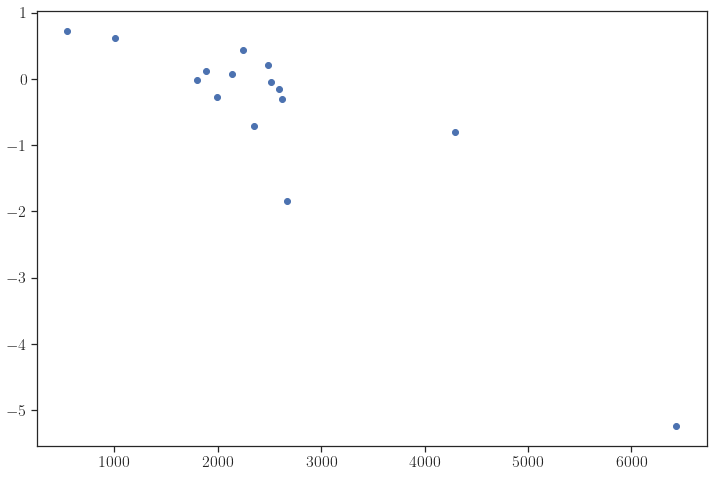

In [499]:
plt.figure(figsize=(12,8))
plt.scatter(split["subword_token_%"] * new_df["test_avg_tokens"], df["dif_grez_ttr"] / df["test_ttr"])

In [352]:
from sklearn.linear_model import LinearRegression

In [353]:
lm = LinearRegression()

In [482]:
X = (split["subword_token_%"] * new_df["test_avg_tokens"]).values.reshape(-1,1) ** 2
y = df["dif_grez_ttr"] / df["test_ttr"]

In [483]:
lm.fit(X, y)

LinearRegression()

In [484]:
lm.coef_, lm.intercept_

(array([-1.33532698e-07]), 0.5891784726288819)

In [487]:
ttr = 0.108219
x = 1803.136201
ttr - (lm.intercept_ + lm.coef_[0] * x**2) * ttr

0.09144250191807268

In [497]:
preds = pd.concat([split["subword_token_%"] * new_df["test_avg_tokens"], df["test_ttr"]], axis=1).apply(
    lambda x: x["test_ttr"] - (lm.intercept_ + lm.coef_[0] * x[0]**2) * x["test_ttr"], axis=1
).values

In [522]:
new_df["reg"] = np.log(split["subword_token_%"] * new_df["test_avg_tokens"])
new_df["y"] = gerz_ttr

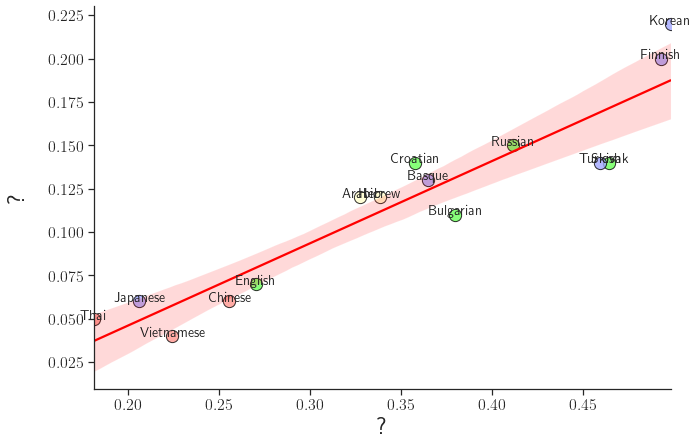

In [527]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

data = new_df
x = "test_twr"
y = "y"
hue = "Group"
size = ""
langs = "Language"

g = sns.lmplot(x=x, y=y, data=data, hue=hue, palette=colors, fit_reg=False, legend=False, 
               height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x=x, y=y, data=data, scatter=False, color="red", ci=95)

for i, row in data.iterrows():
    plt.text(row[x], row[y], row[langs], fontsize=14, 
             horizontalalignment="center")

# plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
#            bbox_to_anchor=(0.6, 0.95), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
#            framealpha=1, edgecolor="black", labelspacing=0.6)

# plt.ylim((40,80))
# plt.xlim((15,75))
plt.ylabel("?", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("?", fontsize=24 +  extra_fontsize)
# plt.title("PoS Average Example Length \n vs Average Performance Over Language", fontsize=28 +  extra_fontsize, pad=30)
# plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_length_vs_accuracy_over_lang.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [335]:
pd.concat([new_df["Language"], bias * 1e3, df[["dif_grez_ttr_%", "dif_grez_ttr"]]], axis=1)

,Language,0,dif_grez_ttr_%,dif_grez_ttr
0,Bulgarian,0.060017,-1.619057,-0.001781
1,English,0.462221,260.334508,0.182234
2,Russian,0.075080,7.219626,0.010829
3,Slovak,0.084450,13.866165,0.019413
4,Croatian,0.046778,-13.379253,-0.018731
5,Chinese,0.047962,79.601546,0.047761
6,Vietnamese,0.102459,157.428125,0.062971
7,Thai,0.001245,-83.982484,-0.041991
8,Finnish,0.058480,-23.273847,-0.046548
9,Basque,0.051449,-21.310251,-0.027703


In [24]:
basic_stats = pd.read_excel("pos_basic_stats.xlsx")

In [37]:
df["Language"].values

array(['Bulgarian', 'English', 'Russian', 'Slovak', 'Croatian', 'Chinese',
       'Vietnamese', 'Thai', 'Finnish', 'Basque', 'Japanese', 'Korean',
       'Turkish', 'Arabic', 'Hebrew'], dtype=object)

In [43]:
wiki = pd.read_excel("all_wiki_sizes.xlsx")

In [45]:
wiki["Articles"] = wiki["Articles"].astype(str).apply(lambda x: x.replace(",", "").replace(".", "")).astype(int)

In [49]:
wiki = pd.merge(df[["Language"]], wiki[["Language", "Articles"]], on="Language", how="left")

In [168]:
split = pd.read_excel("pos_split_word_stats.xlsx")

In [ ]:
pd.concat([df, df[["test_ttr", "test_twr"]].apply(
    lambda x: (x * split["split_word_%"] * split["avg_subwords_per_split"]) / (basic_stats["test_examples"] * basic_stats["test_avg_tokens"])
).rename(columns={"test_ttr": "test_ttr_norm", "test_twr": "test_twr_norm"}) * 1e5], axis=1)

In [107]:
new_df["Articles"] = wiki["Articles"]
new_df["test_examples"] = basic_stats["test_examples"]
new_df["split_word_%"] = split["split_word_%"]
new_df["test_avg_tokens"] = basic_stats["test_avg_tokens"]
new_df["avg_subwords_per_split"] = split["avg_subwords_per_split"]

In [75]:
new_df = utils.add_lang_groups(new_df, "Group")

In [80]:
new_df["test_ttr_norm_by_articles"] = new_df["test_ttr"] / new_df["Articles"]

In [84]:
new_df["test_examples_x_avg_tokens"] = new_df["test_examples"] * new_df["test_avg_tokens"]

In [325]:
new_df["reg"] = split["subword_token_%"] * new_df["test_avg_tokens"]

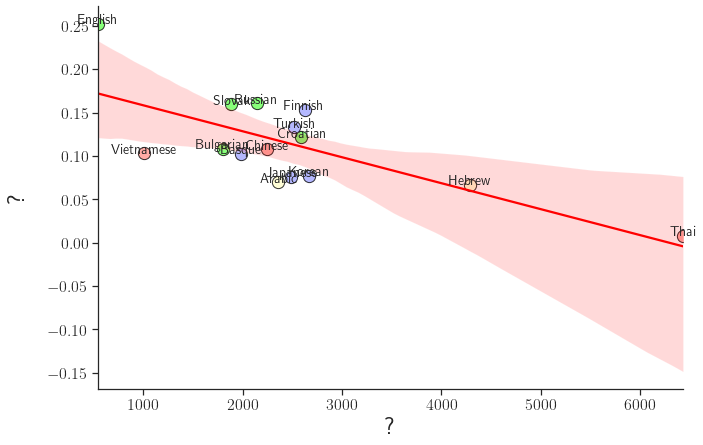

In [327]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

data = new_df
x = "reg"
y = "test_ttr"
hue = "Group"
size = ""
langs = "Language"

g = sns.lmplot(x=x, y=y, data=data, hue=hue, palette=colors, fit_reg=False, legend=False, 
               height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x=x, y=y, data=data, scatter=False, color="red", ci=95)

for i, row in data.iterrows():
    plt.text(row[x], row[y], row[langs], fontsize=14, 
             horizontalalignment="center")

# plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
#            bbox_to_anchor=(0.6, 0.95), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
#            framealpha=1, edgecolor="black", labelspacing=0.6)

# plt.ylim((40,80))
# plt.xlim((15,75))
plt.ylabel("?", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("?", fontsize=24 +  extra_fontsize)
# plt.title("PoS Average Example Length \n vs Average Performance Over Language", fontsize=28 +  extra_fontsize, pad=30)
# plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_length_vs_accuracy_over_lang.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [145]:
pearsonr(x=new_df["test_avg_tokens"] * new_df["split_word_%"], 
         y=new_df["test_ttr"])

(-0.7742760782425344, 0.0007028647465231455)

In [142]:
pearsonr(x=new_df["avg_subwords_per_split"] * new_df["split_word_%"], 
         y=new_df["test_ttr"])

(-0.66907483367037, 0.006377596184525311)

In [147]:
pearsonr(x=new_df["test_examples"] * new_df["test_avg_tokens"] * new_df["split_word_%"], 
         y=new_df["test_ttr"])

(-0.6927576889192166, 0.004197929413841227)

In [188]:
pearsonr(x=split["subword_token_%"] * new_df["test_avg_tokens"], 
         y=new_df["test_ttr"])

(-0.73009187422719, 0.0019992491180696776)

In [ ]:
def sentiment_ttr(info, output, tokenizer):
    lang_name = info["lang_name"]
    file_path = info["file_path"]
    dataset = info["dataset"]
    
    data = pd.read_csv(file_path, header=None)
    data.columns = ["sentiment", "review"]